### Measuring correlations between trip flows X points of interest of Boston metro area
##### This notebook compares number of trips per grid cell and points of interest from Google Places. We use a geodesic buffering to calculate the influence of a POI in the neighboring cells, which is defined in the [Join-Cells-And-POI](ml-models/2.2-Join-Cells-And-POI.ipynb). A POI can be splitted proportionally with the neighboring cells depending on its position, which is defined by the geodesic buffering.  
##### We use Pearson's correlation coefficient and predictive power score in this comparison. 
##### Questions:
* How is the correlation between a POI and the number of bike trips that start or end in the grid cells?
* How is the impact of independent variables on the correlation? The evaluated variables are: cell as origin or destination of the trips, grid size, day period, year period

In [1]:
import pandas as pd
import seaborn as sns
import ppscore as pps
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import bikescience.load_trips as tr
import bikescience.stations as st
import bikescience.grid as grid
import bikescience.flow as flow
import matplotlib.pyplot as plt
#import warnings
#warnings.filterwarnings('ignore')

#### Auxiliary functions

In [2]:
def heatmap_corr(df):
    f, ax = plt.subplots(figsize=(16, 16))
    ax = sns.heatmap(df, vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True)
    ax.set_title('Correlation matrix')
    return ax

def heatmap_pps(df):
    f, ax = plt.subplots(figsize=(16, 16))
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
    ax.set_title('PPS matrix')
    ax.set_xlabel('feature')
    ax.set_ylabel('target')
    return ax

#### Loading trip data

In [3]:
trips = tr.load_all_trips('../data/boston/bike-trips')
print(len(trips), 'trips')
stations = st.load('../data/boston/bike-stations/stations.geojson')
print(len(stations), 'stations')

9427775 trips
324 stations


#### Filtering trips

In [4]:
filtered_trips = trips

#only working days
filtered_trips = tr.working_days(filtered_trips)

#different day periods
#filtered = tr.morning(filtered)
#filtered = filtered[(filtered['hour'] >= 6) & (filtered['hour'] < 9)]
#filtered = filtered[(filtered['hour'] >= 11) & (filtered['hour'] < 14)]
#filtered = filtered[(filtered['hour'] >= 17) & (filtered['hour'] < 20)]

# after a date
#filtered_trips = trips[trips.starttime >= pd.Timestamp('2018-01-01 00:00:0000')]

# between April and November of all years
'''
filtered = trips[((trips.starttime >= pd.Timestamp('2019-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2019-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2019-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2019-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2018-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2018-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2018-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2018-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2017-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2017-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2017-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2017-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2016-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2016-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2016-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2016-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2015-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2015-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2015-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2015-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2014-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2014-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2014-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2014-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2013-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2013-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2013-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2013-12-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2012-04-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2012-06-01 00:00:0000'))) | \
                      ((trips.starttime >= pd.Timestamp('2012-08-01 00:00:0000')) & (trips.starttime < pd.Timestamp('2012-12-01 00:00:0000')))]
'''

print(len(filtered_trips), 'trips')

7007719 trips


#### Creating the OD matrix

In [6]:
the_grid = grid.Grid(n=10)
od = flow.od_countings(trips, the_grid, stations)
od.drop(columns=['origin','destination'],inplace=True)
od.head()

/home/higor/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/higor/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:4326 +type=crs != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


i_start  j_start  i_end  j_end  trip counts
0        0        3      0      3           82
1        0        3      0      5            7
2        0        3      1      3          486
3        0        3      1      4           11
4        0        3      1      5            7

### POIs

In [7]:
base_folder = '../data/boston/training-sets/'
poi = pd.read_csv(base_folder + 'poi/proportional-poi-10x10.csv')
poi.head()

i  j  placement_id  dentist      health     doctor  accounting   finance  \
0  0  0             0     10.0  125.916667  99.916667        3.00  8.500000   
1  0  0             1      9.0  108.750000  86.916667        2.00  6.000000   
2  0  1             0      5.0   56.333333  46.333333        1.00  4.666667   
3  0  1             1      5.0   42.833333  31.250000        2.00  7.000000   
4  0  2             0      1.5  100.833333  76.583333        1.25  6.250000   

     school       gym  ...  bowling_alley  airport  mosque  amusement_park  \
0  6.833333  0.500000  ...            0.0      0.0     0.0             0.0   
1  6.500000  0.500000  ...            0.0      0.0     0.0             0.0   
2  7.250000  1.500000  ...            0.0      0.0     0.0             0.0   
3  5.833333  0.500000  ...            0.0      0.0     0.0             0.0   
4  6.416667  2.333333  ...            0.0      0.0     0.0             0.0   

   embassy  light_rail_station  political  campground  rv_park  zoo  
0      0.0                 0.0        0.0         0.0      0.0  0.0  
1      0.0                 0.0        0.0         0.0      0.0  0.0  
2      0.0                 0.0        0.0         0.0      0.0  0.0  
3      0.0                 0.0        0.0         0.0      0.0  0.0  
4      0.0                 0.0        0.0         0.0      0.0  0.0  

[5 rows x 101 columns]

In [8]:
poi.columns

Index(['i', 'j', 'placement_id', 'dentist', 'health', 'doctor', 'accounting',
       'finance', 'school', 'gym',
       ...
       'bowling_alley', 'airport', 'mosque', 'amusement_park', 'embassy',
       'light_rail_station', 'political', 'campground', 'rv_park', 'zoo'],
      dtype='object', length=101)

#### Getting POIs per origin cells

In [9]:
poi_od_orig = poi.merge(od, left_on=['i', 'j'],right_on=['i_start','j_start'])
poi_od_orig.drop(columns=['i_start','j_start','i_end','j_end'])
poi_od_orig.head()

i  j  placement_id  dentist      health     doctor  accounting  finance  \
0  0  3             0      8.0  109.583333  59.833333    1.083333    12.25   
1  0  3             0      8.0  109.583333  59.833333    1.083333    12.25   
2  0  3             0      8.0  109.583333  59.833333    1.083333    12.25   
3  0  3             0      8.0  109.583333  59.833333    1.083333    12.25   
4  0  3             0      8.0  109.583333  59.833333    1.083333    12.25   

     school       gym  ...  light_rail_station  political  campground  \
0  8.583333  2.833333  ...                 0.0        0.0         0.0   
1  8.583333  2.833333  ...                 0.0        0.0         0.0   
2  8.583333  2.833333  ...                 0.0        0.0         0.0   
3  8.583333  2.833333  ...                 0.0        0.0         0.0   
4  8.583333  2.833333  ...                 0.0        0.0         0.0   

   rv_park  zoo  i_start  j_start  i_end  j_end  trip counts  
0      0.0  0.0        0        3      0      3           82  
1      0.0  0.0        0        3      0      5            7  
2      0.0  0.0        0        3      1      3          486  
3      0.0  0.0        0        3      1      4           11  
4      0.0  0.0        0        3      1      5            7  

[5 rows x 106 columns]

#### Getting POIs per destination cells

In [10]:
poi_od_dest = poi.merge(od, left_on=['i', 'j'],right_on=['i_end','j_end'])
poi_od_dest.drop(columns=['i_start','j_start','i_end','j_end'])
poi_od_dest.head()

i  j  placement_id  dentist      health     doctor  accounting  finance  \
0  0  3             0      8.0  109.583333  59.833333    1.083333    12.25   
1  0  3             0      8.0  109.583333  59.833333    1.083333    12.25   
2  0  3             0      8.0  109.583333  59.833333    1.083333    12.25   
3  0  3             0      8.0  109.583333  59.833333    1.083333    12.25   
4  0  3             0      8.0  109.583333  59.833333    1.083333    12.25   

     school       gym  ...  light_rail_station  political  campground  \
0  8.583333  2.833333  ...                 0.0        0.0         0.0   
1  8.583333  2.833333  ...                 0.0        0.0         0.0   
2  8.583333  2.833333  ...                 0.0        0.0         0.0   
3  8.583333  2.833333  ...                 0.0        0.0         0.0   
4  8.583333  2.833333  ...                 0.0        0.0         0.0   

   rv_park  zoo  i_start  j_start  i_end  j_end  trip counts  
0      0.0  0.0        0        3      0      3           82  
1      0.0  0.0        0        5      0      3            4  
2      0.0  0.0        1        3      0      3          574  
3      0.0  0.0        1        4      0      3           13  
4      0.0  0.0        1        5      0      3            6  

[5 rows x 106 columns]

#### Splitting POIs into groups

In [11]:
poi_group_1 = ['trips','dentist','health','doctor','accounting','finance','school','gym','cemetery','lawyer','park']
poi_group_2 = ['trips','premise','transit_station','furniture_store','home_goods_store','store','general_contractor','bus_station','university','real_estate_agency','beauty_salon']
poi_group_3 = ['trips','food','clothing_store','electrician','car_repair','storage','atm','bank','roofing_contractor','electronics_store','church']
poi_group_4 = ['trips','place_of_worship','hospital','restaurant','veterinary_care','funeral_home','parking','cafe','bakery','convenience_store','liquor_store']
poi_group_5 = ['trips','physiotherapist','car_dealer','pharmacy','insurance_agency','synagogue','gas_station','art_gallery','grocery_or_supermarket','shoe_store','hair_care']
poi_group_6 = ['trips','police','local_government_office','painter','subway_station','moving_company','spa','travel_agency','shopping_mall','florist','plumber']
poi_group_7 = ['trips','laundry','lodging','locksmith','fire_station','car_rental','bar','meal_delivery','meal_takeaway','hindu_temple','jewelry_store']
poi_group_8 = ['trips','library','natural_feature','train_station','department_store','supermarket','post_office','book_store','museum','pet_store','hardware_store']
poi_group_9 = ['trips','car_wash','night_club','stadium','movie_rental','city_hall','courthouse','movie_theater','bicycle_store','bowling_alley','airport']
poi_group_10 = ['trips','mosque','amusement_park','embassy','light_rail_station','political','campground','rv_park','zoo']
poi_group = poi_group_4

In [12]:
poi_aggs = {}
for c in poi_group:
    if c == 'trips':
        poi_aggs[c] = 'sum'
    else:
        poi_aggs[c] = 'first'
poi_aggs

{'trips': 'sum',
 'place_of_worship': 'first',
 'hospital': 'first',
 'restaurant': 'first',
 'veterinary_care': 'first',
 'funeral_home': 'first',
 'parking': 'first',
 'cafe': 'first',
 'bakery': 'first',
 'convenience_store': 'first',
 'liquor_store': 'first'}

#### Choosing origin or destination cells to correlate with POIs

In [13]:
poi_od = poi_od_dest.copy()
poi_od = poi_od.rename(columns={'trip counts': 'trips'})
poi_group.append('i')
poi_group.append('j')
poi_od = poi_od[poi_group]
poi_od.head()

trips  place_of_worship  hospital  restaurant  veterinary_care  \
0     82               6.0  1.333333   18.333333              2.0   
1      4               6.0  1.333333   18.333333              2.0   
2    574               6.0  1.333333   18.333333              2.0   
3     13               6.0  1.333333   18.333333              2.0   
4      6               6.0  1.333333   18.333333              2.0   

   funeral_home  parking  cafe    bakery  convenience_store  liquor_store  i  \
0           0.5      1.0   2.0  2.666667           2.333333      3.333333  0   
1           0.5      1.0   2.0  2.666667           2.333333      3.333333  0   
2           0.5      1.0   2.0  2.666667           2.333333      3.333333  0   
3           0.5      1.0   2.0  2.666667           2.333333      3.333333  0   
4           0.5      1.0   2.0  2.666667           2.333333      3.333333  0   

   j  
0  3  
1  3  
2  3  
3  3  
4  3

In [14]:
poi_od = poi_od.groupby(['i','j'], as_index=False).agg(poi_aggs)
poi_od.drop(columns=['i','j'],inplace=True)
poi_od.head(10)

trips  place_of_worship   hospital  restaurant  veterinary_care  \
0   3028          6.000000   1.333333   18.333333              2.0   
1   4444         28.333333   1.333333   21.333333              0.0   
2   1474         19.166667   1.666667   40.500000              0.0   
3  89130         11.000000   1.833333   21.666667              0.0   
4  16614         14.583333   2.166667   10.250000              0.0   
5   8658         24.333333   1.000000   12.083333              0.0   
6  25710         10.166667   2.500000   16.666667              0.5   
7  19294          2.500000   0.000000    7.750000              0.5   
8   2100          5.166667   0.750000    6.583333              0.0   
9  50614          8.416667  10.666667   19.583333              1.0   

   funeral_home   parking      cafe    bakery  convenience_store  liquor_store  
0      0.500000  1.000000  2.000000  2.666667           2.333333      3.333333  
1      0.000000  1.333333  0.000000  0.000000           9.000000      3.666667  
2      0.000000  2.333333  8.833333  4.333333          17.166667      4.333333  
3      1.000000  1.250000  4.000000  3.000000           1.666667      2.333333  
4      0.500000  1.916667  2.000000  0.333333           3.666667      1.333333  
5      0.833333  0.000000  0.333333  0.000000           8.833333      3.000000  
6      0.000000  2.666667  3.166667  2.666667           7.833333      4.250000  
7      0.000000  4.666667  2.333333  1.666667           1.500000      2.083333  
8      0.333333  0.500000  1.750000  1.333333           0.583333      0.250000  
9      1.000000  8.416667  3.250000  1.333333           2.666667      3.166667

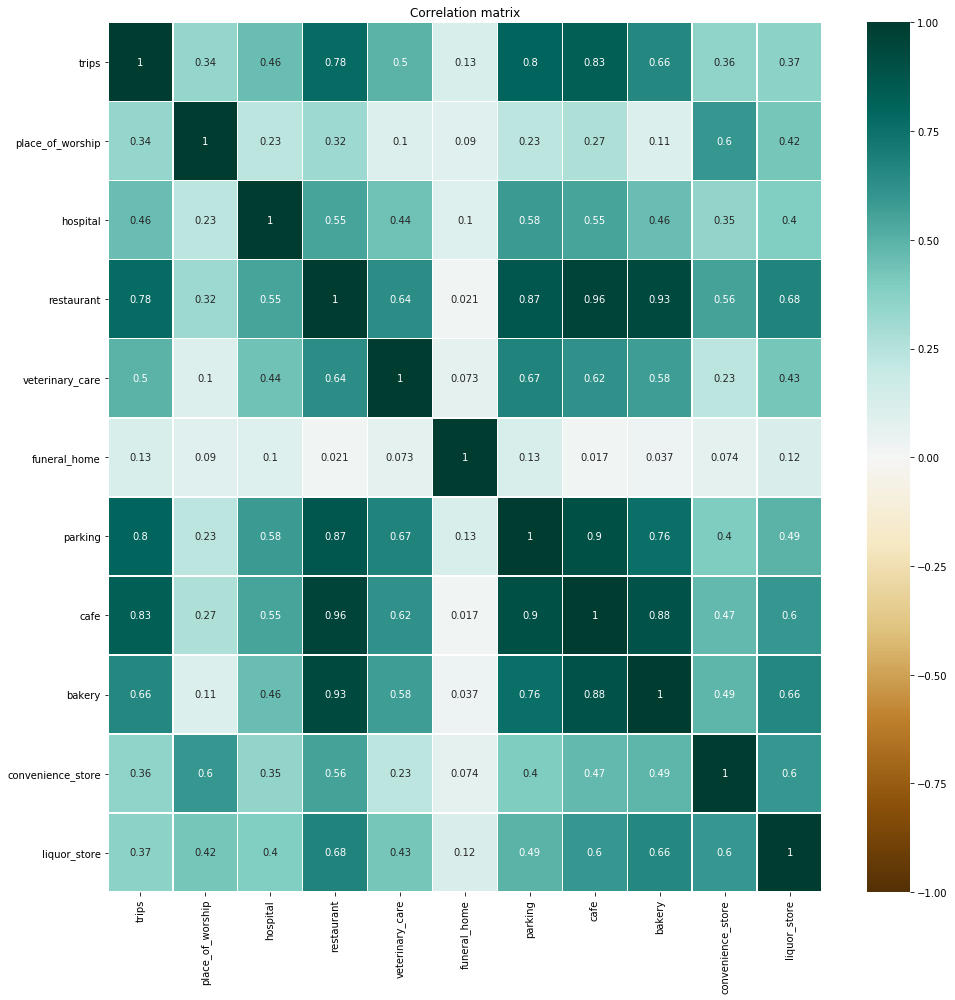

In [15]:
heatmap_corr(poi_od.corr())

/home/higor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)
/home/higor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)
/home/higor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)
/home/higor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit fail

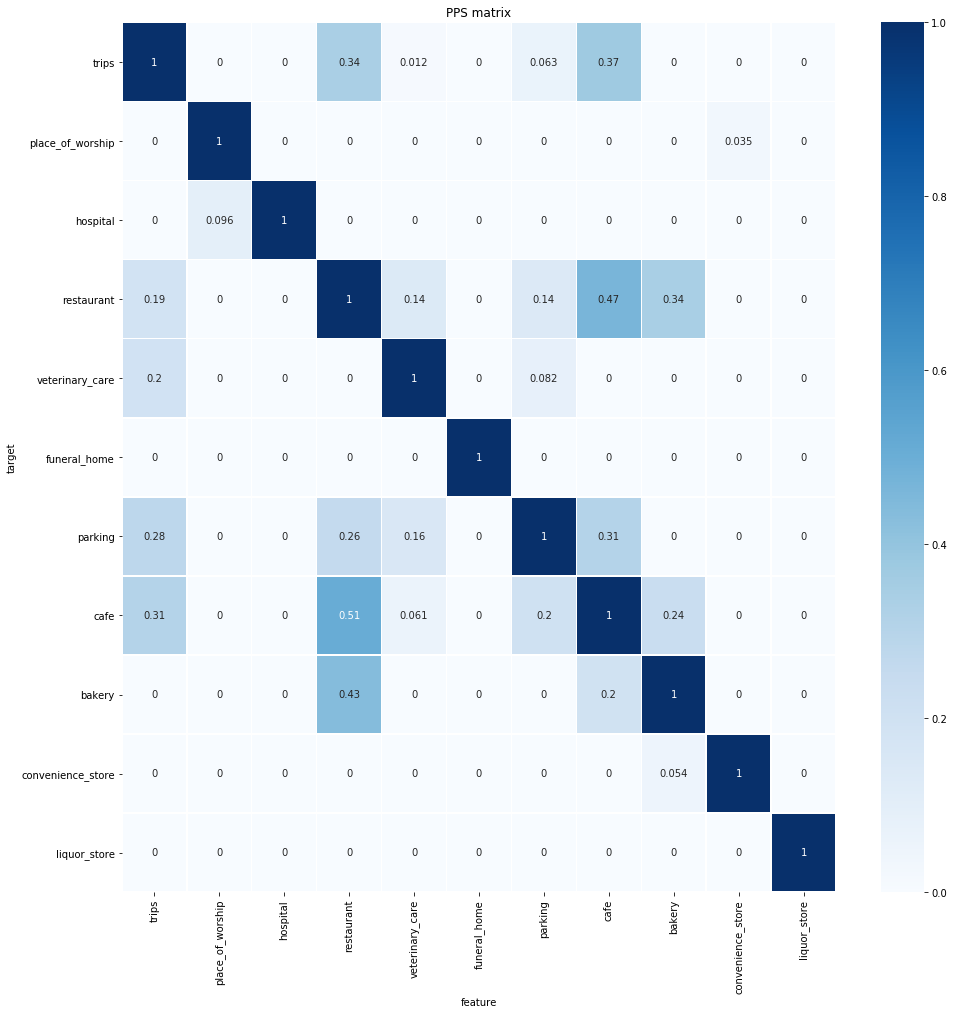

In [16]:
heatmap_pps(pps.matrix(poi_od))